In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import assemble, Aer, transpile, execute
from qiskit import BasicAer
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import ParameterVector
from qiskit.visualization import *

import math 

import sklearn
from sklearn import metrics

import pandas as pd

In [3]:
def getDataWithStatsFeatures(xDropped):
    
    data = pd.DataFrame()
    data['CONS_NO'] = xDropped['CONS_NO']
    data['FLAG'] = xDropped['FLAG']
    data['Mean'] = xDropped.iloc[:,2:].mean(axis=1, skipna=True, numeric_only=True)
    data['Median'] = xDropped.iloc[:,2:].median(axis=1, skipna=True, numeric_only=True )
    data['Standard deviation'] = xDropped.iloc[:,2:].std(axis=1, skipna=True, numeric_only=True)
    data['Variance'] = xDropped.iloc[:,2:].var(axis=1, skipna=True, numeric_only=True )
    data['Kurtosis'] = xDropped.iloc[:,2:].kurtosis(axis=1, skipna=True, numeric_only=True)
    data['Skew'] = xDropped.iloc[:,2:].skew(axis=1, skipna=True, numeric_only=True )
    data['5%'] = xDropped.iloc[:,2:].quantile(axis=1, numeric_only=True, q = 0.05)
    data['10%'] = xDropped.iloc[:,2:].quantile(axis=1, numeric_only=True, q = 0.1)
    data['20%'] = xDropped.iloc[:,2:].quantile(axis=1, numeric_only=True, q = 0.2)
    data['25%'] = xDropped.iloc[:,2:].quantile(axis=1, numeric_only=True, q = 0.25)
    data['30%'] = xDropped.iloc[:,2:].quantile(axis=1, numeric_only=True, q = 0.3)
    data['40%'] = xDropped.iloc[:,2:].quantile(axis=1, numeric_only=True, q = 0.4)
    data['60%'] = xDropped.iloc[:,2:].quantile(axis=1, numeric_only=True, q = 0.6)
    data['75%'] = xDropped.iloc[:,2:].quantile(axis=1, numeric_only=True, q = 0.75)
    data['80%'] = xDropped.iloc[:,2:].quantile(axis=1, numeric_only=True, q = 0.8)
    
    data['Error in mean'] = data['Standard deviation']/len(xDropped.columns)
    
    return data

In [4]:
def getFeaturesLabels(data):
    
    features = np.zeros((len(data), 6))
    features[:,0] = np.array(data['Mean'])
    features[:,1] = np.array(data['Standard deviation'])
    features[:,2] = np.array(data['Variance'])
    features[:,3] = np.array(data['Skew'])
    features[:,4] = np.array(data['Kurtosis'])
    features[:,5] = np.array(data['75%'])

    labels = np.array(data['FLAG'])
    
    return features, labels

In [5]:
def getTrainTestData(features, labels, splitPercentage1 = 0.9, splitPercentage2 = 0.5, inclLabel1inXtrain = True):
    
    if inclLabel1inXtrain == True:
        
        np.random.seed(555555)
        Xtrain = features[labels==1]
        ind1 = np.random.choice(np.arange(0, len(features[labels==1])), int(len(features[labels==1])*splitPercentage2), replace=False)
        ind = np.random.choice(np.arange(len(features[labels==1]), len(features)), int(len(features)*splitPercentage1-len(labels[labels==1])*splitPercentage2), replace=False)
        Xtrain = Xtrain[ind1]
        xt = features[ind]
        Xtrain = np.concatenate((Xtrain, xt))
        Ytrain = np.concatenate((labels[labels==1][ind1], labels[ind]))
        temp = np.arange(Xtrain.shape[0])
        np.random.shuffle(temp)
        Xtrain, Ytrain = Xtrain[temp], Ytrain[temp]
        Xtest1 = np.delete(features, ind, axis=0)[len(labels[labels==1]):]
        Ytest1 = np.zeros((len(Xtest1)), int)
        Xtest2 = np.delete(features[:len(labels[labels==1])], ind1, axis=0)
        Ytest2 = np.ones((len(Xtest2)), int)
        Xtest = np.concatenate((Xtest1, Xtest2))
        Ytest = np.concatenate((Ytest1, Ytest2))
    
    else:

        Xtrain, Xtest, Ytrain, Ytest = sklearn.model_selection.train_test_split(features, labels,
                                                                   train_size = splitPercentage, random_state=45)
    
    return Xtrain, Ytrain, Xtest, Ytest

In [6]:
def ryrzParam(qc, x):
    
    qc.ry(x[0],1)
    qc.rz(x[1],1)
    qc.ry(x[2],2)
    qc.rz(x[3],2)
    qc.ry(x[4],3)
    qc.rz(x[5],3)

    return qc

def ryrzData(qc, x):
    

    qc.ry(x[0],4)
    qc.rz(x[1],4)
    qc.ry(x[2],5)
    qc.rz(x[3],5)
    qc.ry(x[4],6)
    qc.rz(x[5],6)

    
    return qc

In [7]:
def constructCircuit(param, x):
    
    qc = QuantumCircuit(7,1)    
    qc.h(0)
    ryrzParam(qc, param)
    ryrzData(qc, x)
    qc.cswap(0,1,4)
    qc.cswap(0,2,5)
    qc.cswap(0,3,6)
    qc.h(0)
    qc.measure(0, 0)

    return qc

In [8]:
def meas(qc):
    
    backend = BasicAer.get_backend("qasm_simulator")
    job = execute(qc, backend, shots=2^15, seed_simulator=1024, seed_transpiler=1024)
    counts = job.result().get_counts(qc)
    
    if '1' in counts:
        p = counts['1'] / (counts['1'] + counts['0'])
        s = 1 - (2*p)
    else: s = 1
    
    if s<=0: s = 1e-16
        
    return s    

In [9]:
def delForward(param, paramModify, x):
    
    param += paramModify
    qc = constructCircuit(param, x)
    prob = meas(qc)
    
    return prob

In [10]:
def delBackward(param, paramModify, x):
    
    param -= paramModify
    qc = constructCircuit(param, x)
    prob = meas(qc)
        
    return prob

In [11]:
def costFunction(param, x, label):
    
    qc = constructCircuit(param, x)
    prob = meas(qc)
    if label == 1:
        return -np.log(prob)
    else:
        return -np.log(1 - prob)

In [12]:
def runModel(features, labels, paramModify, epochs):

    np.random.seed(55555)
    param0 = np.random.rand(6)* 2 * np.pi #initialize parameter
    param1 = np.random.rand(6)* 2 * np.pi
    loss0 = []
    loss1 = []

    for e in range(epochs):
        l0 = 0
        for i in range(len(features[labels==0])):
        
            delFwd = -np.log(delForward(param0, paramModify, features[labels==0][i]))
            delBwd = -np.log(delBackward(param0, paramModify, features[labels==0][i]))
            l0 += costFunction(param0, features[labels==0][i], label = 0) 
            diff = 0.5 * (delFwd - delBwd)
            param0 -= diff * learningRate

        loss0.append(l0)
        

    for e in range(epochs):
        l1 = 0
        for i in range(len(features[labels==1])):
        
            delFwd = -np.log(delForward(param1, paramModify, features[labels==1][i]))
            delBwd = -np.log(delBackward(param1, paramModify, features[labels==1][i]))
            l1 += costFunction(param1, features[labels==1][i], label = 1)
            diff = 0.5 * (delFwd - delBwd)
            param1 -= diff * learningRate
        

        loss1.append(l1)

    loss = np.array(loss0)+np.array(loss1)
    
    return param0, param1, loss

In [13]:
def predict(Xtest, param0, param1):
    
    Ypred = []

    for i in range(len(Xtest)):
        
        qc0 = constructCircuit(param0, Xtest[i])
        prob0 = meas(qc0)
        qc1 = constructCircuit(param1, Xtest[i])
        prob1 = meas(qc1)
        p0 = prob0 / (prob0 + prob1)
        p1 = prob1 / (prob0 + prob1)
        probs = np.array([p0, p1])
        Ypred.append(np.argmax(probs))
    
    return Ypred

## Quantum Neural Network (QuClassi)
(on 389 datapoints - Completely Balanced Data Set)

In [14]:
x = pd.read_csv('dataTimeSeries.csv')

In [15]:
data = getDataWithStatsFeatures(x)
features, labels = getFeaturesLabels(data)

In [17]:
epochs = 15
learningRate = 0.01
paramModify = np.pi/(2 * np.sqrt(epochs))

# splitPercentage1: percentage of training dataset
# splitPercentage2: percentage of label 1 in training dataset
Xtrain, Ytrain, Xtest, Ytest = getTrainTestData(features, labels, splitPercentage1=0.5, splitPercentage2=0.7, inclLabel1inXtrain=True)
param0, param1, loss = runModel(Xtrain, Ytrain, paramModify, epochs)
Ypred = predict(Xtest, param0, param1)

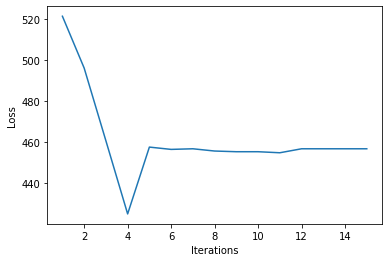

In [18]:
plt.figure()
plt.plot(np.arange(len(loss))+1, loss)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [19]:
param0

array([2.98673486, 7.65544189, 7.1738459 , 7.69702564, 5.00011254,
       5.79051371])

In [20]:
param1

array([ 4.02503395,  4.29960746, -0.30058994,  4.46543711,  4.40139331,
        3.57274115])

In [21]:
print(sklearn.metrics.classification_report(Ypred, Ytest, zero_division=False))

              precision    recall  f1-score   support

           0       0.76      0.97      0.85       147
           1       0.29      0.04      0.07        48

    accuracy                           0.74       195
   macro avg       0.52      0.50      0.46       195
weighted avg       0.64      0.74      0.66       195



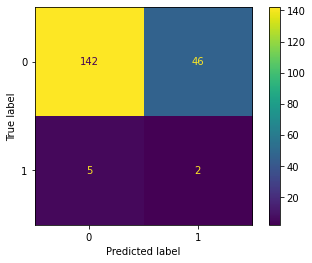

In [22]:
confusionMatrix = metrics.confusion_matrix(y_true=Ytest, y_pred=Ypred)
disp = metrics.ConfusionMatrixDisplay(confusionMatrix)
disp.plot()
plt.show()